In [1]:
!pip install datasets
!pip install evaluate
!pip install transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.4/492.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 970.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from transformers import DataCollatorWithPadding
from dataclasses import dataclass
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from typing import Optional, Union
import torch
from datasets import load_dataset, concatenate_datasets
from transformers import AutoConfig , AutoTokenizer , AutoModel,AutoModelForMultipleChoice, TrainingArguments, Trainer, DefaultDataCollator
from evaluate import load
import numpy as np
import plotly.express as px
import pickle
import pandas as pd

In [ ]:
MODEL_NAME = "bert-base-uncased"

In [ ]:
config = AutoConfig.from_pretrained("bert-base-uncased",hidden_dropout_prob = 0.3, attention_probs_dropout_prob=0.3)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
accuracy = load("accuracy")

In [ ]:
label_mapping_dict = {'A':0, 'B':1, "C":2, "D":3, "E":4}
num_to_label_dict = {0:'A', 1:"B", 2:"C", 3:"D", 4:"E"}

def mapping_func(n):
  return label_mapping_dict[n]

In [ ]:
def preprocess_function(examples):
    question_headers = examples["question"]
    second_sentences = [
        [f"{header}[SEP]{examples['choices'][i]['text'][j]}" for j in range(5)] for i, header in enumerate(question_headers)
    ]

    second_sentences = sum(second_sentences, [])

    tokenized_examples = tokenizer(second_sentences, truncation=True)
    return {k: [v[i : i + 5] for i in range(0, len(v), 5)] for k, v in tokenized_examples.items()}

In [ ]:
riddleSense_train = load_dataset('riddle_sense', split='train')
riddleSense_train_map = load_dataset('riddle_sense', split='train')
riddleSense_val = load_dataset('riddle_sense', split='validation')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3510 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1021 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1184 [00:00<?, ? examples/s]

Dataset riddle_sense downloaded and prepared to /root/.cache/huggingface/datasets/riddle_sense/default/0.1.0/1b311d24c97e1fd41975315faf11fd918a56db0289367a99944ef0fa3dfd6811. Subsequent calls will reuse this data.


In [ ]:
preprocessed_train = riddleSense_train.map(preprocess_function, batched=True)
riddleSense_train_map_pre = riddleSense_train_map.map(preprocess_function, batched=True)
val_pre = riddleSense_val.map(preprocess_function, batched=True)

Map:   0%|          | 0/3510 [00:00<?, ? examples/s]

Map:   0%|          | 0/3510 [00:00<?, ? examples/s]

Map:   0%|          | 0/1021 [00:00<?, ? examples/s]

In [ ]:
@dataclass
class DataCollatorForMultipleChoice:
    """
    Data collator that will dynamically pad the inputs for multiple choice received.
    """

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None

    def __call__(self, features):
        label_name = 'answerKey'
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features
        ]
        flattened_features = sum(flattened_features, [])

        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        new_labels = []
        for label in labels:
          new_labels.append(label_mapping_dict[label])
        batch["labels"] = torch.tensor(new_labels, dtype=torch.int64)
        return batch

Costum Trainer class for creating Data Maps

In [ ]:
class CustomTrainer(Trainer):
    def __init__(self, model, args, train_dataset, eval_dataset, tokenizer, compute_metrics, data_collator):
        super().__init__(model=model, args=args, train_dataset=train_dataset, eval_dataset=eval_dataset,
                         tokenizer=tokenizer, compute_metrics=compute_metrics, data_collator=data_collator)
        self.acc = []
        self.eval_dataset = eval_dataset
        self.labels = torch.tensor([label_mapping_dict[i] for i in self.eval_dataset["answerKey"]])


    def evaluate(self, ignore_keys=None, metric_key_prefix="eval"):
        output = super().evaluate(self.eval_dataset, ignore_keys, metric_key_prefix)
        predictions = self.predict(self.eval_dataset)
        probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions[1]), dim=1)
        pred_labels = torch.argmax(probs, dim=1)
        true_label_probs.append(probs.gather(1, self.labels.unsqueeze(1)).squeeze())
        correctness.append((pred_labels == self.labels).float())
        accuracy = torch.mean((self.labels == pred_labels).float()).item()
        acc.append(accuracy)
        return output

In [ ]:
true_label_probs = []
correctness = []
training_args = TrainingArguments("riddle_sense_check", save_strategy="no", label_names=['answerKey'], evaluation_strategy="epoch", num_train_epochs=3)
model = AutoModelForMultipleChoice.from_pretrained(MODEL_NAME, config=config)
trainer = CustomTrainer(model=model,
                  args=training_args,
                  train_dataset=preprocessed_train.shuffle(),
                  eval_dataset=riddleSense_train_map_pre,
                  tokenizer=tokenizer,
                  compute_metrics=None,
                  data_collator = DataCollatorForMultipleChoice(tokenizer))
trainer.train()
# get predictions
predictions, label_ids, _ = trainer.predict(val_pre)
labels = np.array([i for i in map(mapping_func, val_pre['answerKey'])])
predicted_classes = np.argmax(predictions[1], axis=1)
accuracy = np.mean(labels == predicted_classes)
# Accuracy
print(f'Accuracy: {accuracy}')


In [ ]:
# This training method trains 5 different models, each for an incrementing number of epochs, this is done so we will have more weight on the earlier epochs
# and as such lower bias in our data map, while still collecting information on sample learnability across epochs.
for i in range(1, 6):
  training_args = TrainingArguments("riddle_sense_check", save_strategy="no", label_names=['answerKey'], evaluation_strategy="epoch", num_train_epochs=i)
  model = AutoModelForMultipleChoice.from_pretrained(MODEL_NAME, config=config)
  trainer = CustomTrainer(model=model,
                    args=training_args,
                    train_dataset=preprocessed_train.shuffle(),
                    eval_dataset=riddleSense_train_map_pre,
                    tokenizer=tokenizer,
                    compute_metrics=None,
                    data_collator = DataCollatorForMultipleChoice(tokenizer))
  trainer.train()

In [ ]:
# saving correctness and true_label_prob

# uncomment below if you want to save stats, commented to avoid writting over stats


# data_to_dump = {
#     'correctness': torch.mean(torch.stack(correctness), keepdim=True, dim=0),
#     'true_label_probs': torch.stack(true_label_probs,dim=1)

# }
# with open('/content/drive/MyDrive/stats.pkl', 'wb') as f:
#     pickle.dump(data_to_dump, f)

In [10]:
# load correctness and true_label_prob
with open('/content/drive/MyDrive/stats.pkl', 'rb') as f:
    data_loaded = pickle.load(f)

# Access
correctness = data_loaded['correctness']
true_label_probs = data_loaded['true_label_probs']
confidence = torch.mean(true_label_probs, dim=1) # mean prob of TRUE labels across all instances in eval_data
variability = torch.std(true_label_probs, dim=1, correction=0) # std prob of TRUE labels across all instances in in eval_data


#DataMAP visualization

In [11]:
# Plot the Data Map.

# Compute bins of correctness
bins = np.digitize(correctness, bins=[0.0000001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Create a dictionary to map bin numbers to bin labels
bin_labels = {0:'0', 1: '(0.0-0.1)', 2: '[0.1-0.2)', 3: '[0.2-0.3)', 4: '[0.3-0.4)', 5: '[0.4-0.5)', 6: '[0.5-0.6)',7: '[0.6-0.7)',8: '[0.7-0.8)',9:'[0.8-0.9)',10: '[0.9-1)', 11:'1'}

# Apply the mapping to bins to get bin labels
bins_str = np.vectorize(bin_labels.get)(bins)

colors = px.colors.sample_colorscale("Jet", [n/(11) for n in range(12)])

fig = px.scatter(
    x=variability.numpy().squeeze(),
    y=confidence.numpy().squeeze(),
    color=bins_str.squeeze(),
    symbol=bins_str.squeeze(),
    color_discrete_sequence=colors,
    labels={
        "color": "Correctness",
        "symbol": "Correctness",
        "y": "Confidence",
        "x": "variability"
    },
    category_orders = {"color": list(bin_labels.values())[::-1]}
)
fig.show()

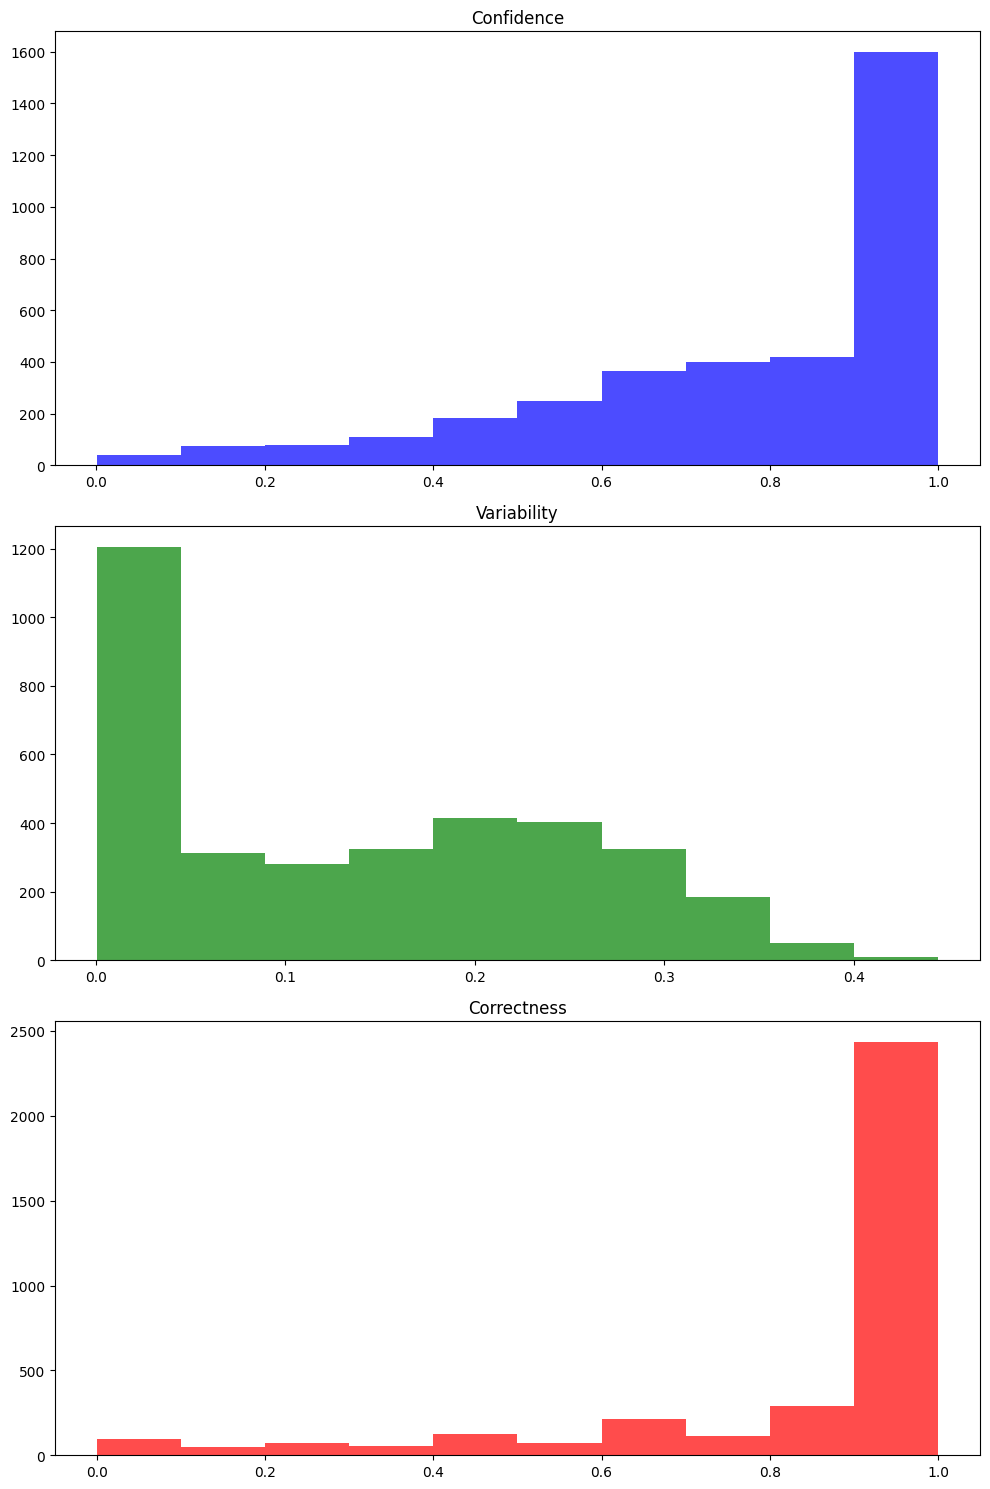

In [ ]:
import matplotlib.pyplot as plt

confidence_np = confidence.numpy().squeeze()
variability_np = variability.numpy().squeeze()
correctness_np = correctness.numpy().squeeze()

# Create subplots for each histogram
fig, axs = plt.subplots(3, figsize=(10, 15))

# Plot histogram for confidence
axs[0].hist(confidence_np, bins=10, color='blue', alpha=0.7)
axs[0].set_title('Confidence')

# Plot histogram for variability
axs[1].hist(variability_np, bins=10, color='green', alpha=0.7)
axs[1].set_title('Variability')

# Plot histogram for correctness
axs[2].hist(correctness_np, bins=10, color='red', alpha=0.7)
axs[2].set_title('Correctness')

# Display the plots
plt.tight_layout()
plt.show()

The scatter plot will contain one point for each evaluation sample.

The x-coordinate of each point will be the variability of the model's predictions for that sample across all epochs, the y-coordinate will be the confidence (the mean model probability of the true label across epochs.) for that sample, and the color and symbol of the point will indicate the bin of the correctness for that sample (how often the model correctly predicted the label of that sample across all epochs).

This visualization will help you to identify patterns in how your model's predictions vary across epochs for different samples. For example, you might see that samples that the model finds harder to classify (those with greater variability and lower confidence) are more likely to be misclassified more often (higher correctness bin).

In [ ]:
def classify_points(confidence_threshold = 0.2, variability_threshold = 0.2):
    hard_to_learn = []
    easy_to_learn=[]
    ambiguous=[]
    for i, datapoint in enumerate(riddleSense_train_map_pre):
      conf = confidence[i]
      var = variability[i]
      # Hard to learn
      if conf < confidence_threshold and var < variability_threshold:
        hard_to_learn.append(i)

      # Easy to learn
      elif conf>= confidence_threshold and var < variability_threshold:
        easy_to_learn.append(i)
      # Ambigious
      else:
        ambiguous.append(i)

    data_dict = {"easy_to_learn": easy_to_learn,
                  "hard_to_learn": hard_to_learn,
                  "ambiguous": ambiguous}
    return data_dict


In [ ]:
data_dict = classify_points(confidence_threshold = 0.2,variability_threshold = 0.23)


easy_to_learn_idx = data_dict["easy_to_learn"]
hard_to_learn_idx = data_dict["hard_to_learn"]
ambiguous_idx = data_dict["ambiguous"]

# assert result == len(trainset)
print(len(easy_to_learn_idx)+len(hard_to_learn_idx) + len(ambiguous_idx))


easy_to_learn_data = riddleSense_train_map_pre.select(easy_to_learn_idx)
hard_to_learn_data = riddleSense_train_map_pre.select(hard_to_learn_idx)
ambiguous_data = riddleSense_train_map_pre.select(ambiguous_idx)

# print quantity and percentages
total_data_num = riddleSense_train_map_pre.num_rows
print(f"Total datapoints: {total_data_num}")
print(f"Easy datapoints: {easy_to_learn_data.num_rows}")
print(f"Hard datapoints: {hard_to_learn_data.num_rows}")
print(f"Ambiguous datapoints: {ambiguous_data.num_rows}")

easy_data_perc = easy_to_learn_data.num_rows/total_data_num
hard_data_perc = hard_to_learn_data.num_rows/total_data_num
ambiguous_data_perc = ambiguous_data.num_rows/total_data_num

print(f"Easy datapoints percentage: {easy_data_perc}")
print(f"Hard_datapoints percentage: {hard_data_perc}")
print(f"Ambiguous datapoints percentage: {ambiguous_data_perc}")


3510
Total datapoints: 3510
Easy datapoints: 2501
Hard datapoints: 103
Ambiguous datapoints: 906
Easy datapoints percentage: 0.7125356125356125
Hard_datapoints percentage: 0.029344729344729346
Ambiguous datapoints percentage: 0.25811965811965815


In [ ]:
# Plot the Data Map based on Hard, Easy, Ambiguous regions
categories = np.empty_like(confidence, dtype = np.str)
categories[easy_to_learn_idx] = "easy_to_learn"
categories[hard_to_learn_idx] = "hard_to_learn"
categories[ambiguous_idx] = "ambiguous"

# Now we plot the Data Map
fig = px.scatter(
    x=variability.numpy().squeeze(),
    y=confidence.numpy().squeeze(),
    color=categories,
    labels={
        "color": "Learning Difficulty",
        "y": "Confidence",
        "x": "Variability"
    },
    category_orders = {"color": ["Easy_to_learn", "ambiguous", "hard_to_learn"]}
)
fig.show()

<ipython-input-18-c3337ef0f73c>:2: DeprecationWarning:

`np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [ ]:
config = AutoConfig.from_pretrained("bert-base-uncased")

Finetune Bert model only on part of the data (easy/hard/ambigious)

In [ ]:
true_label_probs = []
correctness = []
acc = []
training_args = TrainingArguments("riddle_sense_check", save_strategy="no", label_names=['answerKey'], evaluation_strategy="epoch", num_train_epochs=10)
model = AutoModelForMultipleChoice.from_pretrained(MODEL_NAME, config=config)
trainer = CustomTrainer(model=model,
                  args=training_args,
                  train_dataset=ambiguous_data,
                  eval_dataset=val_pre,
                  tokenizer=tokenizer,
                  compute_metrics=None,
                  data_collator = DataCollatorForMultipleChoice(tokenizer))

trainer.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

Epoch,Training Loss,Validation Loss
1,No log,No log
2,No log,No log
3,No log,No log
4,No log,No log
5,0.576300,No log
6,0.576300,No log
7,0.576300,No log
8,0.576300,No log
9,0.003700,No log
10,0.003700,No log


TrainOutput(global_step=1140, training_loss=0.2544804393330164, metrics={'train_runtime': 739.985, 'train_samples_per_second': 12.243, 'train_steps_per_second': 1.541, 'total_flos': 1299931663996920.0, 'train_loss': 0.2544804393330164, 'epoch': 10.0})

In [ ]:
# plotting
# Create a list of epoch numbers
epoch_numbers = list(range(1, 11))

# Create a DataFrame
df = pd.DataFrame({
    'Epoch': epoch_numbers,
    'Accuracy': acc
})

# Create the plot
fig = px.line(df, x='Epoch', y='Accuracy', title='Accuracy over Epochs')
fig.show()

In [ ]:
true_label_probs = []
correctness = []
acc = []
data = easy_to_learn_data
training_args = TrainingArguments("riddle_sense_check", save_strategy="no", label_names=['answerKey'], evaluation_strategy="epoch", num_train_epochs=10)
model = AutoModelForMultipleChoice.from_pretrained(MODEL_NAME, config=config)
trainer = CustomTrainer(model=model,
                  args=training_args,
                  train_dataset=data,
                  eval_dataset=val_pre,
                  tokenizer=tokenizer,
                  compute_metrics=None,
                  data_collator = DataCollatorForMultipleChoice(tokenizer))

trainer.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

Epoch,Training Loss,Validation Loss
1,No log,No log
2,0.641900,No log
3,0.641900,No log
4,0.261200,No log
5,0.142800,No log
6,0.142800,No log
7,0.075700,No log
8,0.038000,No log
9,0.038000,No log
10,0.026600,No log


TrainOutput(global_step=3130, training_loss=0.19083979579206473, metrics={'train_runtime': 1608.6814, 'train_samples_per_second': 15.547, 'train_steps_per_second': 1.946, 'total_flos': 4148530344859740.0, 'train_loss': 0.19083979579206473, 'epoch': 10.0})

In [ ]:
# plotting
# Create a list of epoch numbers
epoch_numbers = list(range(1, 11))

# Create a DataFrame
df = pd.DataFrame({
    'Epoch': epoch_numbers,
    'Accuracy': acc
})

# Create the plot
fig = px.line(df, x='Epoch', y='Accuracy', title='Accuracy over Epochs')
fig.show()

In [ ]:
true_label_probs = []
correctness = []
acc = []
training_args = TrainingArguments("riddle_sense_check", save_strategy="no", label_names=['answerKey'], evaluation_strategy="epoch", num_train_epochs=10)
model = AutoModelForMultipleChoice.from_pretrained(MODEL_NAME, config=config)
trainer = CustomTrainer(model=model,
                  args=training_args,
                  train_dataset=concatenate_datasets([ambiguous_data, ambiguous_data, preprocessed_train]).shuffle(),
                  eval_dataset=val_pre,
                  tokenizer=tokenizer,
                  compute_metrics=None,
                  data_collator = DataCollatorForMultipleChoice(tokenizer))

trainer.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

Epoch,Training Loss,Validation Loss
1,0.783800,No log
2,0.232100,No log
3,0.115200,No log
4,0.025500,No log
5,0.012500,No log
6,0.010400,No log
7,0.001000,No log
8,0.000500,No log
9,0.003400,No log
10,0.000000,No log


TrainOutput(global_step=6660, training_loss=0.09277696331467217, metrics={'train_runtime': 2874.927, 'train_samples_per_second': 18.512, 'train_steps_per_second': 2.317, 'total_flos': 8235435700532760.0, 'train_loss': 0.09277696331467217, 'epoch': 10.0})

In [ ]:
# plotting
# Create a list of epoch numbers
epoch_numbers = list(range(1, 11))

# Create a DataFrame
df = pd.DataFrame({
    'Epoch': epoch_numbers,
    'Accuracy': acc
})

# Create the plot
fig = px.line(df, x='Epoch', y='Accuracy', title='Accuracy over Epochs')
fig.show()